# Supervised Machine Learning: regression and its metrics
Regression in machine learning is a technique used for predicting continuous outcomes. In simple terms, it's like finding the best-fitting line through a scatter plot of data points. This line can then be used to predict future values. For example, if you want to predict the mileage of a car based on its features like weight, horsepower, and displacement, you could use regression. You would plot the average MPG of each car given its features, then use regression to find the relationship between MPG and the features. This relationship can then be used to predict the MPG of other cars based on their features.

---
## 1.&nbsp;Import libraries and files 💾
For this workshop, we'll be using the diamonds dataset from seaborn, which contains information on diamond prices and their attributes, such as carat, cut, color, and clarity.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

---
## 2.&nbsp;The diamond dataset 💎
The dataset provides detailed information about a collection of nearly 54,000 round-cut diamonds. It includes various attributes of each diamond, such as its cut quality, clarity, color, depth, table, price, and dimensions (x, y, z).

* price: price in US dollars
* carat: weight of the diamond
* cut: quality of the cut
* color: diamond colour
* clarity: a measurement of how clear the diamond is
* x: length in mm
* y: width in mm
* z: depth in mm
* depth: total depth percentage
* table: width of top of diamond relative to widest point

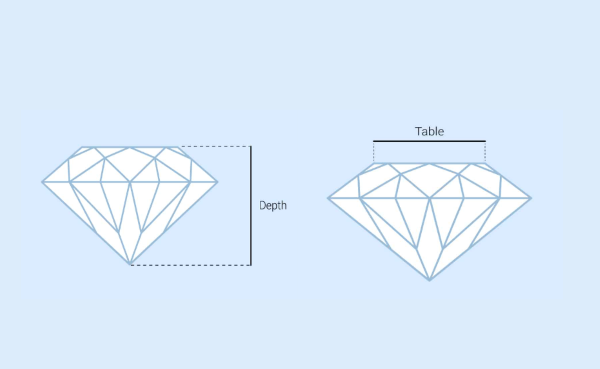


Our goal will be to predict the price of a diamond based on these attributes. Let's start by loading the dataset and exploring its structure.

In [ ]:
diamonds = sns.load_dataset('diamonds')

In [ ]:
diamonds.shape

(53940, 10)

To get a sense of the dataset, let's take a look at the first few rows using the head method:

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [ ]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


---
## 3.&nbsp;Creating a dummy model 🤖
Prior experience leads me to believe that the carat of a diamond can influence its price. Let's look at the relationship between the carat and price columns to see if that's true.

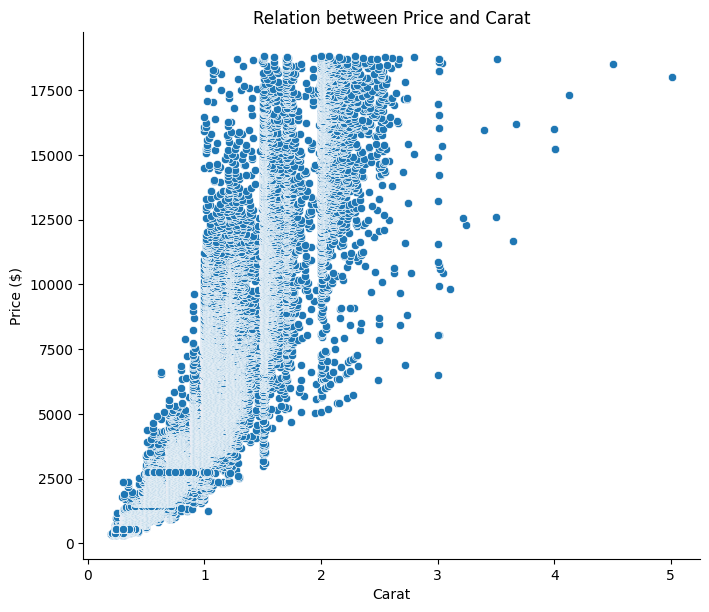

In [ ]:
(
  sns.relplot(data=diamonds,
              x='carat',
              y='price',
              height=6,
              aspect=1.2)
  .set(title='Relation between Price and Carat')
  .set_axis_labels('Carat', 'Price ($)')
);

Looking at our plot of the relationship between carat and price, we can come up with a simple dummy model based on a linear relationship between the two variables. For example, we can assume that the price of a diamond is roughly 6,000 times its carat weight. This would give us a simple model like:

`price = carat * 6000`

Let's plot a line on the chart to see how carat * 6000 would look

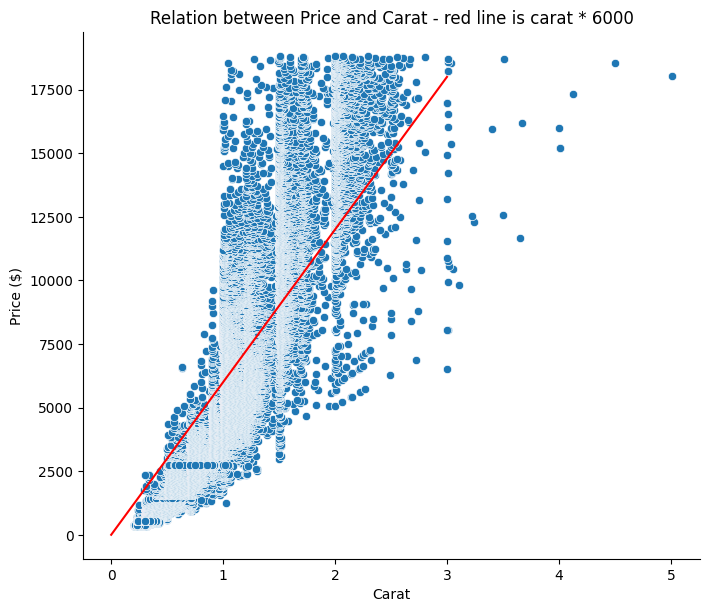

In [ ]:
(
  sns.relplot(data=diamonds,
              x='carat',
              y='price',
              height=6,
              aspect=1.2)
  .set(title='Relation between Price and Carat - red line is carat * 6000')
  .set_axis_labels('Carat', 'Price ($)')
)
plt.plot([0, 3], [0, 18000], 'r-')
plt.show();

This appears to be a decent fit for our dummy model. However, assessing its performance becomes a different challenge compared to classification tasks. In classification, we can easily determine how well our model performs by checking if it correctly predicts the categories. But with regression, where our predictions involve continuous values like prices, they don't fall into distinct categories. Hence, we must employ alternative techniques to evaluate the effectiveness of our regression model.

First, let's create our dummy model as a function so we can use it.

In [ ]:
def dummy_model(carat):
    return carat * 6000

We will soon test our dummy model against SKLearns models, so lets perform a train test split. We'll compare all of the models on how well they perform on the test data.

In [ ]:
X = diamonds.copy()
y = X.pop('price')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now let's make predictions for the test set using our dummy model.

In [ ]:
dummy_y_test_pred = dummy_model(X_test['carat'])

Now that we have our predictions for the test set, we can evaluate how good (or bad) these predictions are.

---
## 4.&nbsp;Assessing a regression model with SKLearn 📈

Metrics serve as quantitative measures to evaluate the model's prediction accuracy compared to the actual target values. The choice of a metric depends on the specific regression task and data nature. Selecting the right metric beforehand is vital for guiding model development, tuning hyperparameters, and making decisions about feature engineering and model architecture. While it's recommended to have one primary evaluation metric as your main goal, examining multiple metrics provides valuable insights into the model's strengths and weaknesses. Here, we'll explore four common metrics to gain a better understanding of their calculations and meanings.

- For a comprehensive list of metrics, check [here](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics).
- To understand each regression metric and when to use them, refer to this [guide](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).

### 4.1.&nbsp;Mean Absolute Error (MAE)
To calculate MAE, we first find the difference between the actual price and the predicted price for each row. Then, we take the absolute value of these differences (which means we ignore negative signs) and find the average of all these absolute differences.

Here's an example:

1. Actual price: 10.0, Predicted price: 8.5
2. Difference: 10.0 - 8.5 = 1.5
3. Absolute difference: |1.5| = 1.5

We repeat this process for all rows and find the average of the absolute differences. That's our Mean Absolute Error! The smaller the MAE, the better our model is at guessing the price.

In [ ]:
from sklearn.metrics import mean_absolute_error

dumb_mae = mean_absolute_error(y_true = y_test,
                               y_pred = dummy_y_test_pred)
dumb_mae

1639.666295884316

### 4.2.&nbsp;Root Mean Square Error
To calculate the Root Mean Squared Error (RMSE), we first find the difference between the actual and the predicted values for each data point. Then, we square these differences, which means we are making all the differences positive and giving more weight to larger differences. After squaring, we find the average of these squared differences and finally, take the square root of this average.

Here's an example:
1. Actual price: 10.0
2. Predicted price: 8.5
3. Difference: 10.0 - 8.5 = 1.5
4. Squared difference: 1.5^2 = 2.25

We repeat this process for all rows, find the average of the squared differences, and take the square root of this average. The smaller the RMSE, the better our model is at predicting the price, with a greater penalty for larger errors as compared to the Mean Absolute Error (MAE).

In [ ]:
from sklearn.metrics import mean_squared_error

dumb_rmse = mean_squared_error(y_true = y_test,
                               y_pred = dummy_y_test_pred,
                               squared=False)
dumb_rmse

1956.2807655420934

### 4.3.&nbsp;Mean Absolute Percentage
To calculate the Mean Absolute Percentage Error (MAPE), we first find the difference between the actual and the predicted values for each data point. Then, we divide each of these differences by the actual value, which gives us the relative error. We take the absolute value of these relative errors to ignore negative signs and then calculate the average of these absolute percentage errors.

Here's an example:
1. Actual price: 10.0
2. Predicted price: 8.5
3. Difference: 10.0 - 8.5 = 1.5
4. Relative error: 1.5 / 10.0 = 0.15
5. Absolute percentage error: |0.15| = 0.15 (15%)

We repeat this process for all rows and find the average of these absolute percentage errors. That's our Mean Absolute Percentage Error! The smaller the MAPE, the better our model is at predicting prices, with each error being a percentage of the actual value.

MAPE is a very intuitive measure because it directly tells us how far off our predictions are on average in terms of percentage. For example, a MAPE of 0.20 means that our predictions are, on average, 20% off from the actual prices. A lower MAPE indicates more accurate predictions.

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

dumb_mape = mean_absolute_percentage_error(y_true = y_test,
                                           y_pred = dummy_y_test_pred)
dumb_mape

0.9384528370170875

### 4.4.&nbsp;R Squared 🧮
R-squared, also referred to as the coefficient of determination, measures the proportion of variance in the y (target labels) that can be explained by the model's predictions based on X (the feature matrix). With R-squared values ranging from 0 to 1, higher scores indicate a better fit, suggesting that the model can more effectively capture the variations in the target labels based on the features provided.

In [ ]:
from sklearn.metrics import r2_score

dumb_r2 = r2_score(y_true = y_test,
                   y_pred = dummy_y_test_pred)

dumb_r2

0.759257884013869

---
## 5.&nbsp;Creating a SKLearn model 🧠
SKLearn has a great [guide for models](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

First off, before we do anything with models, we'll set up a preprocessor.

In [ ]:
X_cat = X_train.select_dtypes(exclude = 'number').columns
X_num = X_train.select_dtypes(include = 'number').columns

cut = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color = ['D','E','F','G','H','I','J']
clarity = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

preprocessor = ColumnTransformer(transformers=[
    ('category', OrdinalEncoder(categories=[cut, color, clarity]), X_cat),
    ('number', "passthrough", X_num)
])

### 5.1.&nbsp;DecisionTreeRegressor

In [ ]:
dt_pipeline = make_pipeline(preprocessor,
                            StandardScaler(),
                            DecisionTreeRegressor())

dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('category',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['D',
                                                                              'E',
                                                                              'F',
                                                                              'G',
                                                                              'H',
                                                                              'I',
                                                                              'J'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  Index(['cut', 'color', 'clarity'], dtype='object')),
                                                 ('number', 'passthrough',
                                                  Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])),
                ('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor())])

Predicting with the DecisionTreeRegressor

In [ ]:
dt_predictions = dt_pipeline.predict(X_test)

How well is the DecisionTreeRegressor performing? Let's compare the R-squared with our dummy model

In [ ]:
dt_r2 = r2_score(y_true = y_test,
                 y_pred = dt_predictions)

pd.DataFrame({"R2": [dumb_r2, dt_r2]},
             index=["dumb_model", "decision_tree"])

,R2
dumb_model,0.759258
decision_tree,0.966482


That's a big improvement! Let's see how a few other models perform.

### 5.2.&nbsp;SGDRegressor

In [ ]:
sgd_pipeline = make_pipeline(preprocessor,
                            StandardScaler(),
                            SGDRegressor())

sgd_pipeline.fit(X_train, y_train)

sgd_predictions = sgd_pipeline.predict(X_test)

### 5.3.&nbsp;LinearRegression

In [ ]:
lr_pipeline = make_pipeline(preprocessor,
                            StandardScaler(),
                            LinearRegression())

lr_pipeline.fit(X_train, y_train)

lr_predictions = lr_pipeline.predict(X_test)

---
## 6.&nbsp;Comparing our SKLearn models 🔍

In [ ]:
sgd_r2 = r2_score(y_true = y_test,
                  y_pred = sgd_predictions)
lr_r2 = r2_score(y_true = y_test,
                 y_pred = lr_predictions)

comparing_models_df = pd.DataFrame({"R2": [dumb_r2, dt_r2, sgd_r2, lr_r2]},
                                    index=["dumb_model", "decision_tree", "sgd", "linear_regression"])

comparing_models_df

,R2
dumb_model,0.759258
decision_tree,0.966482
sgd,0.905476
linear_regression,0.905664


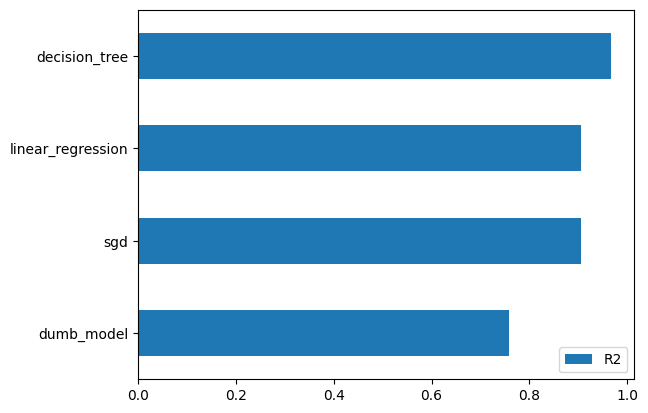

In [ ]:
(
    comparing_models_df
    .sort_values(by='R2')
    .plot.barh()
);

Based on the R-squared scores provided, the Decision Tree model stands out as the best performer. A higher R-squared score indicates that the model can explain a larger proportion of the variance in the target labels (y) based on the features (X); meaning it can better capture the underlying relationships between the input features and the target labels, resulting in more accurate predictions.

---
## 7.&nbsp;Assessing a regression model manually 👀
Beyond examining the individual output metrics from SKLearn, we can gain deeper insights by visualising the calculated differences and plotting them. This approach allows us to evaluate the performance of our regression model more comprehensively.

### 7.1.&nbsp;Histogram of errors
By examining the histogram, we can assess if the errors follow a normal distribution, detect outliers, and identify any skewed data, ultimately aiding us in refining our model and addressing potential issues.

#### 7.1.1.&nbsp; Histogram of errors - dummy model
To construct the histogram, we begin by computing the errors. We expand our test set with two columns: the actual price and the predicted price. By examining the difference between these columns, we can evaluate the errors made by our model.

In [ ]:
dummy_errors_df = X_test.copy()
dummy_errors_df["price"] = y_test
dummy_errors_df["prediction"] = dummy_y_test_pred
dummy_errors_df["error"] = dummy_errors_df["prediction"] - dummy_errors_df["price"]

Now that we have the error calculated for each row we can plot it.

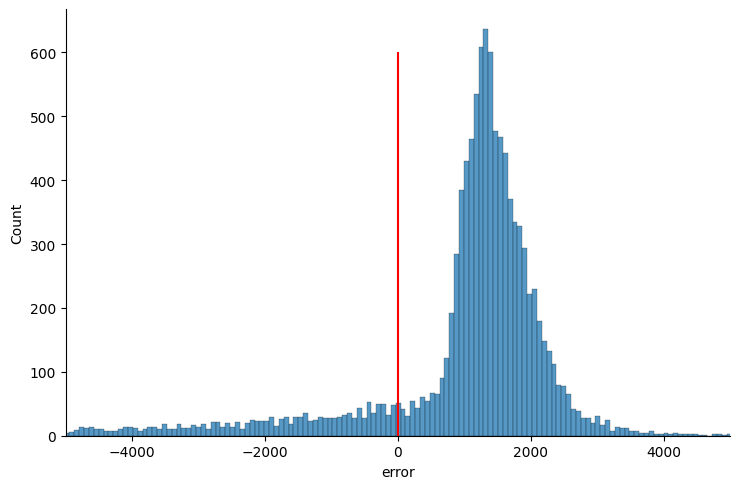

In [ ]:
sns.displot(dummy_errors_df['error'],
            aspect=1.5)
plt.vlines(x=0,
           ymin=0,
           ymax=600,
           color='red')
plt.xlim(-5000,
         5000)
plt.show()

Our dumb model's predictions exhibit a left-skewed distribution, indicating a consistent tendency to overpredict the diamond prices. Specifically, there is a prominent peak on the right-hand side, where the model frequently overestimates the price by approximately $1700.

#### 7.1.2.&nbsp;Histogram of errors - decision tree model

In [ ]:
dt_errors_df = X_test.copy()
dt_errors_df["price"] = y_test
dt_errors_df["prediction"] = dt_predictions
dt_errors_df["error"] = dt_errors_df["prediction"] - dt_errors_df["price"]

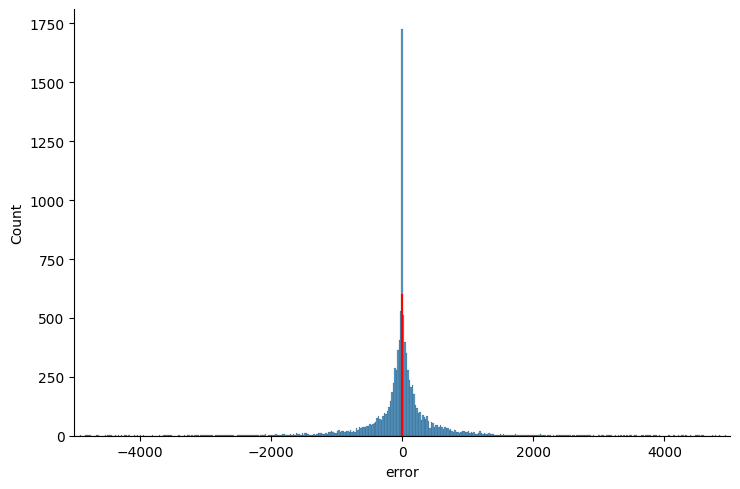

In [ ]:
sns.displot(dt_errors_df['error'],
            aspect=1.5)
plt.vlines(x=0,
           ymin=0,
           ymax=600,
           color='red')
plt.xlim(-5000,
         5000)
plt.show()

We can see from our decision tree model that it is much more even handed in its over- and underestimation of the price. Also, there are significantly less large errors here compared to the dummy model.

### 7.2.&nbsp;Scatterplot of errors
A scatterplot can help guide us in a similar manner to a histogram

#### 7.2.1.&nbsp; Scatterplot of errors - dummy model

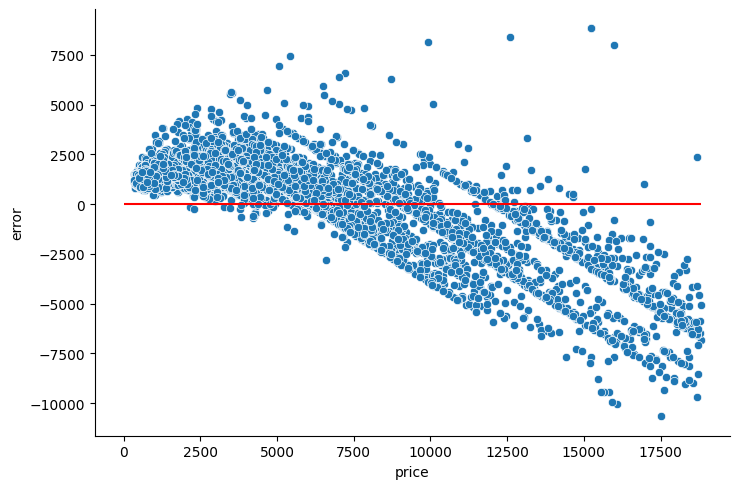

In [ ]:
sns.relplot(data=dummy_errors_df,
            x='price',
            y='error',
            aspect=1.5)
plt.hlines(y=0,
           xmin=0,
           xmax=max(dummy_errors_df['price']),
           color='red')
plt.show()

We can see that the more expensive the diamonds become, the worse our model is at predicting the price.

#### 7.2.2.&nbsp;Scatterplot of errors - decision tree model

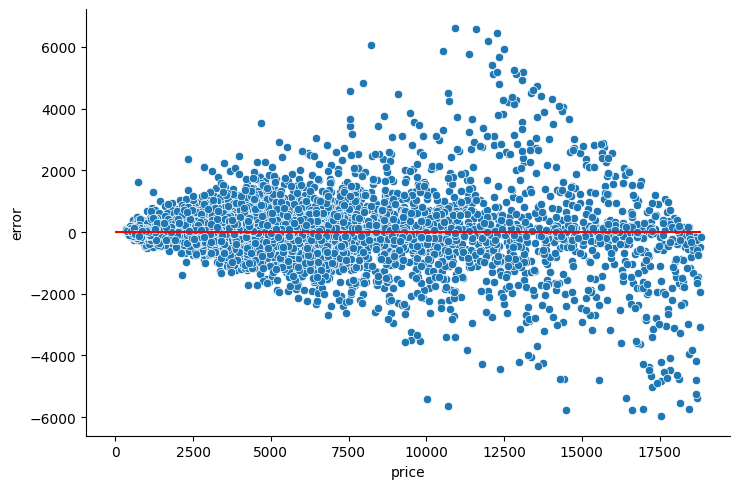

In [ ]:
sns.relplot(data=dt_errors_df,
            x='price',
            y='error',
            aspect=1.5)
plt.hlines(y=0,
           xmin=0,
           xmax=max(dt_errors_df['price']),
           color='red')
plt.show()

From the y-axis range, it is evident that the decision tree performs better in predicting the price overall. The increased symmetry in the plot indicates that the model is not solely overpredicting or underpredicting, showing a balanced performance. However, the model still struggles with predicting prices for expensive diamonds. Remember, all models are wrong, but some are useful. Is our decision tree model useful? If yes, where would it be useful?